# Synthetic Data (Poisson-Log-Normal)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy 
import matplotlib.pyplot as plt
import seaborn

import time
import pyro
import pyro.poutine as poutine
import pyro.distributions as dist

from pyro.infer.autoguide import AutoDelta, AutoDiagonalNormal, AutoGuideList
from torch.distributions import constraints
from pyro.infer import Predictive

### Helper functions

In [3]:
def plot_few_gene_hist(cell_types_n, counts_ng, other_counts_ng=None, ncols=4):
    assert len(cell_types_n.shape) == 1 
    assert len(counts_ng.shape) == 2
    assert other_counts_ng is None or counts_ng.shape == other_counts_ng.shape
    assert counts_ng.shape[0] == cell_types_n.shape[0]
    
    def _to_torch(_x):
        if isinstance(_x, torch.Tensor):
            return _x
        elif isinstance(_x, numpy.ndarray):
            return torch.tensor(_x)
        else:
            raise Exception("Expected torch.tensor or numpy.ndarray. Received {0}".format(type(_x)))
    
    counts_ng = _to_torch(counts_ng)
    other_counts_ng = None if other_counts_ng is None else _to_torch(other_counts_ng)
    
    ctypes = torch.unique(cell_types_n)
    genes = counts_ng.shape[-1]
    
    
    nrows = genes
    ncols = len(ctypes)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    for r in range(genes):
        tmp = counts_ng[:,r]
        other_tmp = None if other_counts_ng is None else other_counts_ng[:,r]
        for c, c_type in enumerate(ctypes):
            tmp2 = tmp[cell_types_n == c_type]
            other_tmp2 = None if other_counts_ng is None else other_tmp[cell_types_n == c_type]
            if other_counts_ng is not None:
                barWidth=0.4
                
                y = torch.bincount(tmp2)
                x = torch.arange(y.shape[0]).cpu().numpy()
                other_y = torch.bincount(other_tmp2)
                other_x = torch.arange(other_y.shape[0]).cpu().numpy() + barWidth
                
                _ = axes[r,c].bar(x, y.cpu().numpy(), width = barWidth)
                _ = axes[r,c].bar(other_x, other_y.cpu().numpy(), width = barWidth)
            else:
                y = torch.bincount(tmp2)
                x = numpy.arange(y.shape[0])
                barWidth=0.9
                _ = axes[r,c].bar(x, y, width = barWidth)
    plt.close()
    return fig


def EMD_between_distributions(distA, distB, normalize: bool=False):
    """
    Eearth mover's distance (aka  Wasserstein distance) has a close form solution in 1D.
    See https://en.wikipedia.org/wiki/Wasserstein_metric)
    """

    sizeA = distA.shape[-1]
    sizeB = distB.shape[-1]
    max_size = max(sizeA, sizeB)
    min_size = min(sizeA, sizeB)
    delta_size = max_size - min_size
    
    padder = torch.nn.ConstantPad1d(padding=(0, delta_size), value=0)
    _distA = padder(distA)[...,:max_size]
    _distB = padder(distB)[...,:max_size]
    
    if normalize:
        normA = _distA.sum(dim=-1, keepdim=True)
        normB = _distB.sum(dim=-1, keepdim=True)
        _distA /= normA
        _distB /= normB
    
    # Actual caltulation 
    _distA_cum = torch.cumsum(_distA, axis=-1)
    _distB_cum = torch.cumsum(_distB, axis=-1)    
    EMD = (_distA_cum - _distB_cum).abs().sum(axis=-1)
    return EMD


def L1_between_distributions(distA, distB, normalize: bool=False):
    """ Simple L1 distance between two distributions. """
    sizeA = distA.shape[-1]
    sizeB = distB.shape[-1]
    max_size = max(sizeA, sizeB)
    min_size = min(sizeA, sizeB)
    delta_size = max_size - min_size
    
    padder = torch.nn.ConstantPad1d(padding=(0, delta_size), value=0)
    _distA = padder(distA)[...,:max_size]
    _distB = padder(distB)[...,:max_size]
    
    if normalize:
        normA = _distA.sum(dim=-1, keepdim=True)
        normB = _distB.sum(dim=-1, keepdim=True)
        _distA /= normA
        _distB /= normB
    
    # Actual calculation
    L1_norm = (_distA - _distB).abs().sum(axis=-1)
    return L1_norm


def compute_median_logprob_per_gene_and_cell_type(cell_types_n, log_prob_ng):
    assert len(log_prob_ng.shape) >= 2
    
    unique_cell_types = torch.unique(cell_types_n)
    k = len(unique_cell_types)
    g = log_prob_ng.shape[-1]
    
    median_kg = torch.zeros((k,g))
    for ik, ctype in enumerate(unique_cell_types):
        log_prob_kg = log_prob_ng[..., cell_types_n == ctype, :].flatten(end_dim=-2)
        assert len(log_prob_kg.shape) == 2
        median_kg[ik] = torch.median(log_prob_kg, axis=-2)[0] 
    return median_kg



def compute_per_cell_type_distributions(cell_types_n, counts_ng):
    """
    Computes the per-cell-type distribution of all the genes
    
    Args:
        cell_types_n: 
        counts_ng:
    
    Returns:
        dist_kgi a tensor of shape (cell_types, genes, max_counts) whose entry represent the number of cells 
        of type k with i counts for gene g.  
    """
    counts_ng = counts_ng.int()
    
    unique_cell_types = torch.unique(cell_types_n)
    i_max = torch.max(counts_ng).item() + 1
    k = len(unique_cell_types)
    g = counts_ng.shape[-1]
    
    dist_kgi = torch.zeros((k,g,i_max))

    for ik, ctype in enumerate(unique_cell_types):
        counts_kg = counts_ng[cell_types_n == ctype]
        for ig in range(g):
            dist_kgi[ik,ig, :] = torch.bincount(counts_kg[:,ig], minlength=i_max) 
    return dist_kgi


def plot_log_prob(cell_types_n, log_prob_ng, other_log_prob_ng=None, ncols=4, bins=20):
    assert len(cell_types_n.shape) == 1 
    assert len(log_prob_ng.shape) >= 2
    assert cell_types_n.shape[0] == log_prob_ng.shape[-2]
    assert other_log_prob_ng is None or (log_prob_ng.shape == other_log_prob_ng.shape)
    
    def _to_torch(_x):
        if isinstance(_x, torch.Tensor):
            return _x
        elif isinstance(_x, numpy.ndarray):
            return torch.tensor(_x)
        else:
            raise Exception("Expected torch.tensor or numpy.ndarray. Received {0}".format(type(_x)))
    
    other_log_prob_ng = None if other_log_prob_ng is None else _to_torch(other_log_prob_ng)
    log_prob_ng = _to_torch(log_prob_ng)
    ctypes = torch.unique(cell_types_n)
    genes = log_prob_ng.shape[-1]
    
    nrows = genes
    ncols = len(ctypes)
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))

    for r in range(genes):
        tmp = log_prob_ng[...,r]
        other_tmp = None if other_log_prob_ng is None else other_log_prob_ng[..., r]
        for c, c_type in enumerate(ctypes):
            if other_log_prob_ng is None:
                tmp2 = tmp[..., cell_types_n == c_type]
                y, x = numpy.histogram(tmp2, bins=bins, density=True)
                barWidth = 0.9 * (x[1]-x[0]) 
                _ = axes[r,c].bar(x[:-1], y, width = barWidth)
            else:
                tmp2 = tmp[..., cell_types_n == c_type].flatten()
                other_tmp2 = other_tmp[..., cell_types_n == c_type].flatten()
                myrange = (min(min(tmp2), min(other_tmp2)).item(), max(max(tmp2), max(other_tmp2)).item())
                y, x = numpy.histogram(tmp2, range=myrange, bins=bins, density=True)
                other_y, other_x = numpy.histogram(other_tmp2, range=myrange, bins=bins, density=True)
                barWidth = 0.4 * (x[1]-x[0]) 
                _ = axes[r,c].bar(x[:-1], y, width = barWidth)
                _ = axes[r,c].bar(other_x[:-1]+barWidth, other_y, width = barWidth)
       
    plt.close()
    return fig

### Generate fake data and visualize

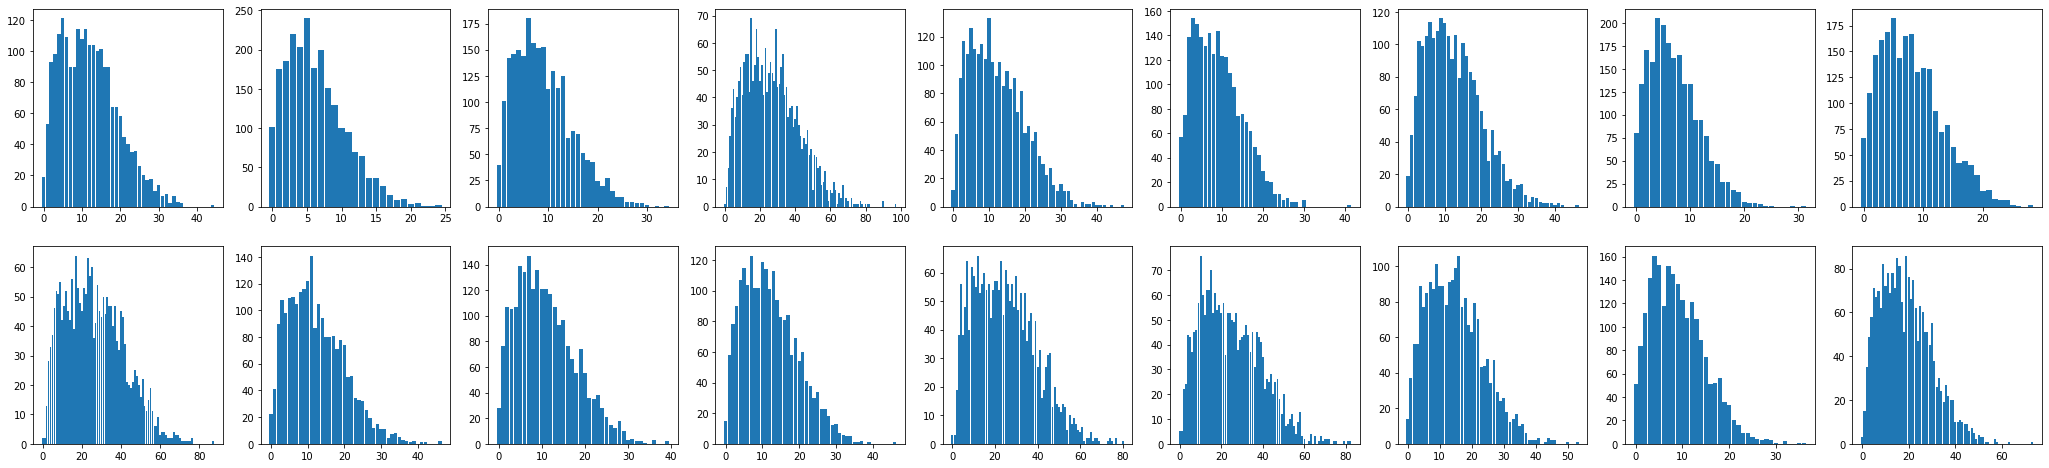

In [4]:
from tissue_purifier.model_utils.gene_regression import (
    generate_fake_data, 
    GeneDataset, 
    model_poisson_log_normal, 
    guide_poisson_log_normal,
    train_helper,
    train_test_val_split
)

fake_dataset: GeneDataset = generate_fake_data(
    cells=20000,
    genes=500,
    covariates=20,
    cell_types=9,
    alpha_scale=0.01,
    alpha0_loc=-5.0,
    alpha0_scale=0.5,
    noise_scale= 0.1)
    
    
counts_ng = fake_dataset.counts
cell_types_n = fake_dataset.cell_type_ids
fig = plot_few_gene_hist(cell_types_n, counts_ng[:,:2])
fig

# Model

  Trace Shapes:                   
   Param Sites:                   
          eps_g                500
         alpha0        9     1 500
  Sample Sites:                   
     cells dist                  |
          value          20000   |
       log_prob                  |
cell_types dist                  |
          value              9   |
       log_prob                  |
 covariate dist                  |
          value             20   |
       log_prob                  |
     genes dist                  |
          value            500   |
       log_prob                  |
     alpha dist     9 20   500   |
          value     9 20   500   |
       log_prob     9 20   500   |
    counts dist 20000  1   500   |
          value 20000  1   500   |
       log_prob 20000  1   500   |


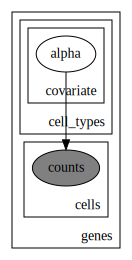

In [5]:
trace = poutine.trace(model_poisson_log_normal).get_trace(fake_dataset)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

pyro.render_model(model_poisson_log_normal, model_kwargs={"dataset": fake_dataset})            

# Train/Test/Val split

In [17]:
train_list, test_list, val_list = train_test_val_split(fake_dataset.counts, 
                                                       fake_dataset.cell_type_ids, 
                                                       fake_dataset.covariates,
                                                       stratify=True)

# from here
train, cross_validation, test on 
read scoring metrics:
    
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.67.3696&rep=rep1&type=pdf

# Train all versions 

In [ ]:
filename_list, guide_list, use_covariates_list = [], [], []
for n, guide in enumerate([guide_MAP, guide_eps, guide_eps_alpha]):
    for use_cov in [True, False]:

        filename = "params_model_"+str(n)+"_COV.pt" if use_cov else "params_model_"+str(n)+"_NO_COV.pt"
        filename_list.append(filename)
        guide_list.append(guide)
        use_covariates_list.append(use_cov)
                
        print()
        print()
        print("=================")
        print("Starting training:", filename)
        start_time = time.time()
        train(model, guide, 
              model_kargs = {"dataset": fake_dataset, 
                             "observed": True, 
                             "use_covariates": use_cov}, 
              n_steps=1, #2001, 
              print_frequency=50,
              clear_param_store=True)
        delta_time = time.time()-start_time
        print("Traning time was {0:.3f} seconds".format(delta_time))
    
        print("Params")
        for name, value in pyro.get_param_store().items():
            print(name, pyro.param(name).shape)
        print("Alpha0 is zero? -->", torch.all(pyro.param("alpha0") == 0.0).item())
        print("Alpha  is zero? -->", torch.all(pyro.param("alpha_loc") == 0.0).item())
            
        pyro.get_param_store().save(filename=filename)

# Evaluate the models (i.e. compute log_prob)

In [ ]:
true_counts_ng = fake_dataset["counts"]
num_samples = 2

log_prob_list = []
for n, (file, guide, use_cov) in enumerate(zip(filename_list, guide_list, use_covariates_list)):
    print()
    print()
    print("{0} --> {1}".format(n, file))
    
    # Load the trained model
    pyro.clear_param_store()
    pyro.get_param_store().load(filename=file)
        
    # compute the predictions
    predictive = Predictive(model, guide=guide, num_samples=num_samples,)
    samples = predictive.get_samples(fake_dataset, observed=False, use_covariates=use_cov)
    print(samples.keys())
    
    print("Q/A")
    print("Is eps_g deterministic? --->", torch.all(samples["eps_g"][0] == samples["eps_g"][1]))
    print("Is alpha deterministic? --->", torch.all(samples["alpha"][0] == samples["alpha"][1]))
    print("Is eps_n1g deterministic? ->", torch.all(samples["eps_n1g"][0] == samples["eps_n1g"][1]))
    print("Is counts deterministic? -->", torch.all(samples["counts"][0] == samples["counts"][1]))
    
    rates_ng = samples["rate_n1g"].squeeze(dim=-2)
    log_prob_ng = dist.Poisson(rate=rates_ng).log_prob(true_counts_ng)    
    log_prob_list.append(log_prob_ng)  

### Plot the log prob distribution for one model

In [ ]:
tmp_log_prob = log_prob_list[0]
print("log_prob_shape -> (n_samples, n_cells, n_genes)", tmp_log_prob.shape)

# fig = plot_log_prob(cell_types_n, tmp_log_prob[...,:2], ncols=4)
fig = plot_log_prob(cell_types_n, tmp_log_prob[...,:2], tmp_log_prob[...,:2]+1, ncols=4) 
fig

### Heatmap with the median log_prob for gene and cell_type

In [ ]:
nmax = len(log_prob_list)
ncol = 3
nrow = int(numpy.ceil(float(nmax)/ncol))
fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(4*ncol, 4*nrow))

for n, log_prob in enumerate(log_prob_list):
    r,c = int(n / ncol), n % ncol
    median_kg = compute_median_logprob_per_gene_and_cell_type(cell_types_n, tmp_log_prob)
    mean_log_prob = median_kg.mean()
    _ = seaborn.heatmap(median_kg, cmap="inferno", robust=True, ax=axes[r,c])
    _ = axes[r,c].set_title("mean_log_prob = {0:.3f}".format(mean_log_prob))

### Connect log_prob to p-value

my_lambda = -2 (log_prob_0 - log_prob)  -> lambda should be positive

If Null Hypothesis is True my_lambda ~ ChiSquaredDistribution

In [ ]:
def convert_log_prob_to_pvalues(
    log_prob_full: torch.Tensor, 
    log_prob_null: torch.Tensor, 
    cell_types_n: torch.Tensor,
    l: int):
    
    assert log_prob_full.shape == log_prob_null.shape 
    assert len(log_prob_full.shape) >= 2
    assert len(cell_types_n.shape) == 1 and cell_types_n.shape[0] == log_prob_full.shape[-2]
    
    if log_prob_full >= 2:
        log_prob_full = log_prob_full.meadian(dim=-3)[0]
        log_prob_null = log_prob_null.meadian(dim=-3)[0]
    
    unique_cell_types = torch.unique(cell_types_n)
    for c, ctype in enumerate(unique_cell_types):
        mask_k = (cell_types_n == ctype)
        log_prob_full_kg = log_prob_full[...,mask_k,:]
        log_prob_null_kg = log_prob_null[...,mask_k,:]
        
        my_lambda_kg = (log_prob_full_kg - log_prob_full_kg).flatten(end_dim=-2).sum(dim=0)
        
        
        

In [ ]:
fake_dataset.other_covariates

In [ ]:
log_prob_list[0].sum() - log_prob_list[1].sum()

In [ ]:
my_lambda = -2 * (log_prob_list[0].sum() - log_prob_list[1].sum())

# If 

In [ ]:
plt.plot

In [ ]:
compute_log_ratio, use cki_square to translate to p-value

### Show the log_prob heat map

In [ ]:
assert 1==2

# FROM HERE. DO THE SUMMARY PLOT

In [ ]:
median_kg = compute_median_logprob_per_gene_and_cell_type(cell_types_n, tmp_log_prob)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(median_kg, cmap="inferno", robust=True, ax=axes[0,0])
_ = axes[0,0].set_title("log_prob model 1")

# FROM HERE

### Just for visualization: Plot the predicted_counts vs the real_counts

In [ ]:
pyro.get_param_store().load(filename="params_model_C.pt")
predictive_C = Predictive(model_poisson_log_normal_C, guide=guide_poisson_log_normal_C, num_samples=2,)
                        #return_sites={"counts"})
samples_C = predictive_C.get_samples(fake_dataset, observed=False)
for k, v in samples_C.items():
    print(f"{k}: {tuple(v.shape)}")

In [ ]:
assert torch.any(samples_A["counts"][0] != samples_A["counts"][1])
assert torch.any(samples_B["counts"][0] != samples_B["counts"][1])
assert torch.any(samples_C["counts"][0] != samples_C["counts"][1])

In [ ]:
cell_types_n = fake_dataset["cell_type_codes"]
true_counts_ng = fake_dataset['counts']
predA_counts_ng = samples_A["counts"][0].squeeze()
predB_counts_ng = samples_B["counts"][0].squeeze()
predC_counts_ng = samples_C["counts"][0].squeeze()

print(cell_types_n.shape, true_counts_ng.shape, predA_counts_ng.shape, predB_counts_ng.shape, predC_counts_ng.shape)

In [ ]:
fig_A = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predA_counts_ng[:,:2].int(), ncols=3)
fig_B = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predB_counts_ng[:,:2].int(), ncols=3)
fig_C = plot_few_gene_hist(cell_types_n, true_counts_ng[:,:2], predC_counts_ng[:,:2].int(), ncols=3)

In [ ]:
_ = fig_A.suptitle("MLE estimates")
fig_A

In [ ]:
_ = fig_B.suptitle("MAP estimates")
fig_B

In [ ]:
_ = fig_C.suptitle("MAP estimates. No priors on alpha0")
fig_C

## Quantify the variance 
1. at the level of distributions
2. at the level of single predictions

### at the level of distributions

In [ ]:
true_dist_kgi = compute_per_cell_type_distributions(cell_types_n, true_counts_ng)
predA_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predA_counts_ng)
predB_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predB_counts_ng)
predC_dist_kgi = compute_per_cell_type_distributions(cell_types_n, predC_counts_ng)

In [ ]:
L1_norm_A = L1_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
L1_norm_B = L1_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
L1_norm_C = L1_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

EMD_norm_A = EMD_between_distributions(true_dist_kgi, predA_dist_kgi, normalize=True)
EMD_norm_B = EMD_between_distributions(true_dist_kgi, predB_dist_kgi, normalize=True)
EMD_norm_C = EMD_between_distributions(true_dist_kgi, predC_dist_kgi, normalize=True)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
_ = fig.suptitle("Distance between true counts distribution and estimates")

_ = seaborn.heatmap(L1_norm_A, cmap="inferno", robust=True, ax=axes[0,0])
_ = seaborn.heatmap(L1_norm_B, cmap="inferno", robust=True, ax=axes[0,1])
_ = seaborn.heatmap(L1_norm_C, cmap="inferno", robust=True, ax=axes[0,2])
_ = axes[0,0].set_title("L1 wrt MLE estimates")
_ = axes[0,1].set_title("L1 wrt MAP estimates")
_ = axes[0,2].set_title("L1 wrt MAP estimates, alpha0 no prior")

_ = seaborn.heatmap(EMD_norm_A, cmap="inferno", robust=True, ax=axes[1,0])
_ = seaborn.heatmap(EMD_norm_B, cmap="inferno", robust=True, ax=axes[1,1])
_ = seaborn.heatmap(EMD_norm_C, cmap="inferno", robust=True, ax=axes[1,2])
_ = axes[1,0].set_title("EMD wrt MLE estimates")
_ = axes[1,1].set_title("EMD wrt MAP estimates")
_ = axes[1,2].set_title("EMD wrt MAP estimates, alpha0 no prior")

In [ ]:
print(L1_norm_A.median(), L1_norm_B.median(), L1_norm_C.median())
print(EMD_norm_A.median(), EMD_norm_B.median(), EMD_norm_C.median())

## At the level of single predictions

In [ ]:
from tissue_purifier.misc_utils.validation import (
    create_null_distribution,
    create_heldout_distribution
)

null_dist = create_null_distribution(
    cell_types_n=cell_types_n, 
    counts_ng=counts_ng[:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)   


heldout_dist = create_heldout_distribution(
    cell_types_n=cell_types_n, 
    true_counts_ng=counts_ng[:,:10], 
    pred_counts_ng=counts_ng[:,:10]+1,
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)   

### test the procedure by creating two fake distributions

In [ ]:
null_dist = create_null_distribution(
    cell_types_n=cell_types_n[-1000:], 
    counts_ng=counts_ng[-1000:,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

heldout_dist = create_null_distribution(
    cell_types_n=cell_types_n[:1000], 
    counts_ng=counts_ng[:1000,:10], 
    similarity_measure="L1",
    boundaries=torch.linspace(start=0, end=30, steps=31),
)     

In [ ]:
gene_id = 1

x_null = null_dist["cell_type_0"][gene_id,:] / numpy.sum(null_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][gene_id,:] / numpy.sum(heldout_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

In [ ]:
gene_id = 6

x_null = null_dist["cell_type_0"][gene_id,:] / numpy.sum(null_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)
x_heldout = heldout_dist["cell_type_0"][gene_id,:] / numpy.sum(heldout_dist["cell_type_0"][gene_id,:], axis=-1, keepdims=True)

barWidth=0.4
plt.bar(null_dist["boundaries"], 
        x_null, 
        width = barWidth,
       label="null")
plt.bar(heldout_dist["boundaries"]+barWidth, 
        x_heldout,
        width = barWidth,
       label="Heldout")
_ = plt.xlim([-1,20])
_ = plt.legend()
_ = plt.title("Distribution of Chi = |counts - counts|")

### Two-sample Kolmogorov–Smirnov test
I am asking the question if the two distribution are the same


In [ ]:
from scipy.interpolate import interp1d
from typing import NamedTuple, Union
    
class KS_test(NamedTuple):
    """ 
    Result of the KS test between two empirical distributions.
    """
    x: numpy.ndarray
    f1: numpy.ndarray
    f2: numpy.ndarray
    gap: numpy.ndarray
    ks: Union[float, numpy.ndarray]
    n1: Union[int, numpy.array]
    n2: Union[int, numpy.array]
        

def compute_pvalue_from_ks(ks_test: KS_test) -> numpy.ndarray:
    """
    Compute the p-value using the asymptotic formula 
    see. https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
    """
    n1 = ks_test.n1
    n2 = ks_test.n2
    D = ks_test.ks
    tmp = (2 * D * D * n1 * n2) / (n1 + n2)
    p = 2 * numpy.exp(-tmp)
    return p

    
def compute_KS_test(x1, histo1, x2, histo2) -> KS_test:
    
    # (empirical) cumulative distribution and size of sample
    F1_tmp = histo1.cumsum(axis=-1) # shape (genes, bins)
    n1 = F1_tmp[...,-1:]            # shape (genes, 1)
    F1 = F1_tmp / n1                # shape (genes, bins)
    
    # (empirical) cumulative distribution and size of sample
    F2_tmp = histo2.cumsum(axis=-1) 
    n2 = F2_tmp[..., -1:]
    F2 = F2_tmp / n2
    
    # Interpolate sample 1 on the spacing of sample 2 
    f_interp = interp1d(x1, F1, axis=-1, fill_value=(0.0, 1.0))
    F1_new = f_interp(x2)
    
    # Comute the maximum gap between empirical cumulative distributions
    gap = numpy.abs(F1_new - F2)
    ks = numpy.max(gap, axis=-1, keepdims=True)
    
    return KS_test(x=x2, f1=F1_new, f2=F2, n1=n1, n2=n2, gap=gap, ks=ks)


key_cell_types = []
for key in null_dist.keys():
    if key.startswith("cell_type_"):
        key_cell_types.append(key)
    

#df = pandas.DataFrame()
for k in key_cell_types:        
    
    ks_test_tmp = compute_KS_test(
        x1=null_dist["boundaries"], 
        histo1=null_dist["cell_type_0"], 
        x2=heldout_dist["boundaries"], 
        histo2=heldout_dist["cell_type_0"])
    
    p_values_tmp = compute_pvalue_from_ks(ks_test_tmp)
    
    
    
#    dfdf = pd.DataFrame(columns=["firstname", "lastname"])
#df = df.append({
#     "firstname": "John",
#     "lastname":  "Johny"
#      }, ignore_index=True)
    
    dict_tmp = {'ks' : ks_test_tmp.ks, 'p_value': p_values_tmp, 'cell_type': [k]*len(p_values_tmp)}

In [ ]:
ncol = 4
nmax = len(ks_test.ks)
nrow = int(numpy.ceil(float(nmax) / ncol))

fig, axes = plt.subplots(ncols=ncol, nrows=nrow, figsize=(4*ncol, 4*nrow))
for n in range(nmax):
    r,c = n // ncol, n % ncol
    axes[r,c].plot(ks_test.x, ks_test.f1[n,:])
    axes[r,c].plot(ks_test.x, ks_test.f2[n,:])
    axes[r,c].plot(ks_test.x, ks_test.gap[n,:])
    axes[r,c].set_xlim([0,20])
    axes[r,c].set_title("ks={0:.3} -> pvalue={1:.3}".format(ks_test.ks[n].item(), p_values[n].item()))